In [216]:
import numpy as np
import pandas as pd
import glob
import os
from odf import text, teletype
from odf.opendocument import load
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Get the current working directory
cwd = os.getcwd()

print(f'Current working directory: {cwd}')


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Current working directory: c:\Users\mobil\OneDrive\Desktop\FRA532_Exam\src\doc


# **Data preparation**

In [217]:
def calculate_subtraction(column):
    # Split each entry by the '-' delimiter
    split_values = column.str.split('-', expand=True)
    # Convert the resulting substrings into numbers
    num1 = pd.to_numeric(split_values[0])
    num2 = pd.to_numeric(split_values[1])
    # Calculate the difference between the two numbers
    result = num1 - num2
    return result

In [218]:
# Path to your ODS file
ods_file_path = os.path.join(cwd, 'expresult.ods')
print(f'Path to the ODS file: {ods_file_path}')

# Load the ODS file
doc = load(ods_file_path)

# Extract text from the ODS file
content = []
for text_node in doc.getElementsByType(text.P):
    content.append(teletype.extractText(text_node))

# Print the extracted content
# for line in content:
#     print(line)


Path to the ODS file: c:\Users\mobil\OneDrive\Desktop\FRA532_Exam\src\doc\expresult.ods


## **x เเละ y ที่หุ่นยนต์เดินได้**

In [219]:
x_y_robot_ground_truth_csv = os.path.join(cwd, 'expresult.csv')

x_y_robot_ground_truth_list = []
x_y_robot_ground_truth_data = pd.read_csv(x_y_robot_ground_truth_csv, index_col=False)
x_y_robot_ground_truth_list.append(x_y_robot_ground_truth_data)
x_y_robot_ground_truth = pd.concat(x_y_robot_ground_truth_list, ignore_index=True)

x_y_robot_ground_truth.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,default,0.025,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,x,y,NaN,NaN,cov,0.025,NaN,cov,0.005,NaN,cov,0.045
3,NaN,1,201.4,25.7-20,NaN,NaN,x,y,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2,201,20-14.1,NaN,1.0,201.6,20-17.2,1.0,201.9,20-9.2,1.0,202.3,20-10.7


### x เเละ y เมื่อทำการปรับค่า cov เป็น 0.005 , 0.025 เเละ 0.045

In [220]:
x_y_robot_cov5 = x_y_robot_ground_truth.iloc[4:14, 9:11].rename(columns={'Unnamed: 9':'x_cov5', 'Unnamed: 10':'raw_y_cov5'})
x_y_robot_cov25 = x_y_robot_ground_truth.iloc[4:14, 6:8].rename(columns={'Unnamed: 6':'x_cov25', 'Unnamed: 7':'raw_y_cov25'})
x_y_robot_cov45 = x_y_robot_ground_truth.iloc[4:14, 12:].rename(columns={'Unnamed: 12':'x_cov45', 'Unnamed: 13':'raw_y_cov45'})

x_y_robot_cov5['y_cov5'] = calculate_subtraction(x_y_robot_cov5['raw_y_cov5'])
x_y_robot_cov25['y_cov25'] = calculate_subtraction(x_y_robot_cov25['raw_y_cov25'])
x_y_robot_cov45['y_cov45'] = calculate_subtraction(x_y_robot_cov45['raw_y_cov45'])

x_y_robot_cov5 = x_y_robot_cov5.drop(columns=["raw_y_cov5"]).reset_index(drop =True)
x_y_robot_cov25 = x_y_robot_cov25.drop(columns=["raw_y_cov25"]).reset_index(drop =True)
x_y_robot_cov45 = x_y_robot_cov45.drop(columns=["raw_y_cov45"]).reset_index(drop =True)

multi_index = pd.MultiIndex.from_product([['cov_5', 'cov_25', 'cov_45'], ['x', 'y']], names=['lv1', 'lv_2'])
all_x_y_cov_df = pd.concat([x_y_robot_cov5, x_y_robot_cov25, x_y_robot_cov45], axis=1)
all_x_y_cov_df.columns = multi_index
all_x_y_cov_df.head()



lv1   cov_5       cov_25      cov_45     
lv_2      x     y      x    y      x    y
0     201.9  10.8  201.6  2.8  202.3  9.3
1     201.1   5.7    202  7.3  201.4  9.4
2     202.8   6.6  201.6  5.7  201.7  4.6
3     201.9   6.7  202.3  5.5    202  7.5
4     202.4   4.9  200.5  2.9  201.9  1.3

### x เเละ y เมื่อทำการสั่ง cmd_vel 0.1 m/s ในเวลา 20 วินาที

In [221]:
x_y_robot = x_y_robot_ground_truth.iloc[3:, 2:4]
x_y_robot = x_y_robot.rename(columns={'Unnamed: 2':'x_robot', 'Unnamed: 3':'raw_y_robot'})

x_y_robot['y_robot'] = calculate_subtraction(x_y_robot['raw_y_robot'])
x_y_robot = x_y_robot.drop(columns=["raw_y_robot"]).reset_index(drop = True)
x_y_robot.head()

,x_robot,y_robot
0,201.4,5.7
1,201,5.9
2,201.4,2.2
3,201.5,10.1
4,200.9,13.4


# **1.การทดลองหาความสัมพันธ์ในการสั่งงานมอเตอร์ Dynamixel** 

ตัวแปรต้น: Comand_velocity (rpm) SI 

ตัวแปรตาม: Wheel_velocity (rpm) 

ตัวแปรควบคุม: Environment (Air/Floor) 

## **สมมติฐาน**

เมื่อทำการแปลงค่าที่อ่านได้จาก Dynamixel เป็นค่าที่กำหนดจากการหาความสัมพันธ์แล้ว ความเร็วล้อที่วัดได้ของหุ่นยนต์เมื่อเดินบนอากาศจะต้องมีค่าใกล้เคียงกับความเร็วที่สั่งไป และความเร็วล้อที่วัดได้ของหุ่นยนต์เมื่อเดินบนพื้น ผลของแรงเสียดทานที่เกิดขึ้นที่ล้อส่งผลต่อความเร็วที่สั่งจาก command_velocity ทำให้ความเร็วของ wheel_velocity ลดลง  

## **ขั้นตอนการทดลอง**  

ในการทดลองนี้นั้นจะแบ่งการทดลองออกเป็น 2 ส่วน ส่วนแรกคือการทดลองโดยสั่งให้ล้อของหุ่นยนต์หมุนในอากาศซึ่งไม่มีแรงเสียดทาน และอีกส่วนคือการทดลองโดยให้หุ่นยนต์เดินบนพื้นซึ่งมีแรงเสียดทาน 

In [222]:
EX1_DATA_PATH = cwd + "\\experiment_1"
EXPR_NUM = 1

print(f'Path to the experiment 1 data: {EX1_DATA_PATH}')

Path to the experiment 1 data: c:\Users\mobil\OneDrive\Desktop\FRA532_Exam\src\doc\experiment_1


In [223]:
def read_data(data_path, expr_num, rpm, id_num, base_df):

    dpath = data_path + '\\Experiment_' + str(expr_num) + '_' + str(rpm) + '_id_' + str(id_num) + '.csv'
    df = pd.read_csv(dpath)
    # Add the experiment rpm to the dataframe
    df['rpm'] = rpm
    # Concatenate the dataframes
    if base_df.empty:
        base_df = df
    else:
        base_df = pd.concat([base_df, df], ignore_index=True)

    return base_df

In [224]:
def plot_experimet_data(df):
    #Plot df Data
    time = df['time']
    right_wheel = df['left_wheel_vel']
    left_wheel = df['right_wheel_vel']
    tar_rpm = df['rpm'][0]

    # Convert to np array
    time = np.array(time)
    right_wheel = np.array(right_wheel)
    left_wheel = np.array(left_wheel)

    # Calculate Mean
    mean_right_wheel = np.mean(right_wheel)
    mean_left_wheel = np.mean(left_wheel)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(time, right_wheel, label='Right Wheel')
    ax.plot(time, left_wheel, label='Left Wheel')
    ax.axhline(mean_right_wheel, color='r', linestyle='--', label='Mean Right Wheel')
    ax.axhline(mean_left_wheel, color='g', linestyle='--', label='Mean Left Wheel')
    ax.axhline(tar_rpm, color='b', linestyle='--', label='Target RPM')
    ax.legend()
    plt.yticks(np.arange(tar_rpm-5,tar_rpm+5,1))
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (rpm)')
    plt.title(f'Target RPM: {tar_rpm}, Right Wheel Mean: {mean_right_wheel:.2f}, Left Wheel Mean: {mean_left_wheel:.2f}')

    print(f'Right Wheel difference from target: {mean_right_wheel - tar_rpm:.2f}')
    print(f'Left Wheel difference from target: {mean_left_wheel - tar_rpm:.2f}')

## **ผลการทดลอง**

### **เปรียบเทียบ standard divation ของความเร็วที่ทดลองบนอากาศเทียบกับที่พื้น**

Right Wheel difference from target: -0.58
Left Wheel difference from target: -0.64


,time,left_wheel_vel,right_wheel_vel,rpm
count,250.000000,250.000000,250.000000,250.0
mean,25.099733,69.421806,69.363181,70.0
std,14.462611,1.859172,1.579061,0.0
min,0.199919,63.203998,65.952002,70.0
25%,12.649729,68.699996,68.699996,70.0
50%,25.099763,69.615997,68.699996,70.0
75%,37.549578,70.531999,70.531999,70.0
max,49.999875,75.112000,73.279998,70.0


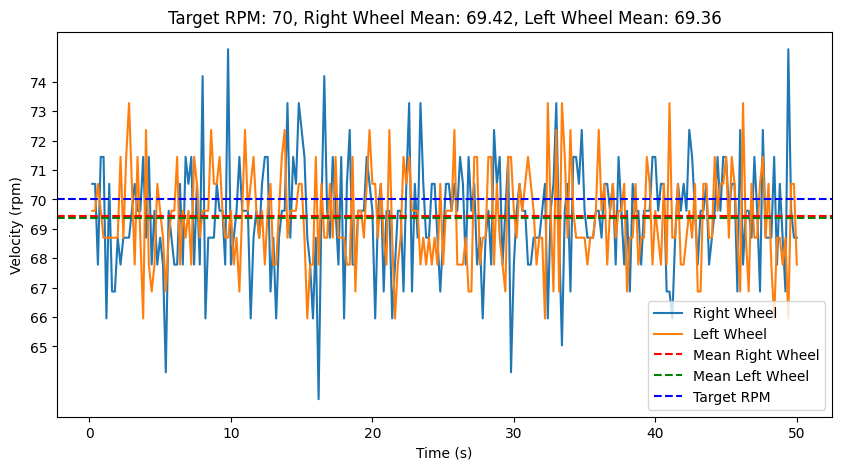

In [225]:
sample_df = pd.DataFrame(columns=['time', 'left_wheel_vel', 'left_wheel_vel', 'rpm'])
sample_df = read_data(EX1_DATA_PATH, EXPR_NUM, rpm=70, id_num=0, base_df=sample_df)
plot_experimet_data(sample_df)
sample_df.describe()

Right Wheel difference from target: -0.58
Left Wheel difference from target: -0.75


,time,left_wheel_vel,right_wheel_vel,rpm
count,250.000000,250.000000,250.000000,250.0
mean,25.099757,69.418141,69.249597,70.0
std,14.462602,1.949912,1.529240,0.0
min,0.199625,65.036005,65.952002,70.0
25%,12.649499,67.783995,68.699996,70.0
50%,25.099698,69.615997,68.699996,70.0
75%,37.549961,70.531999,69.615997,70.0
max,49.999815,75.112000,74.195999,70.0


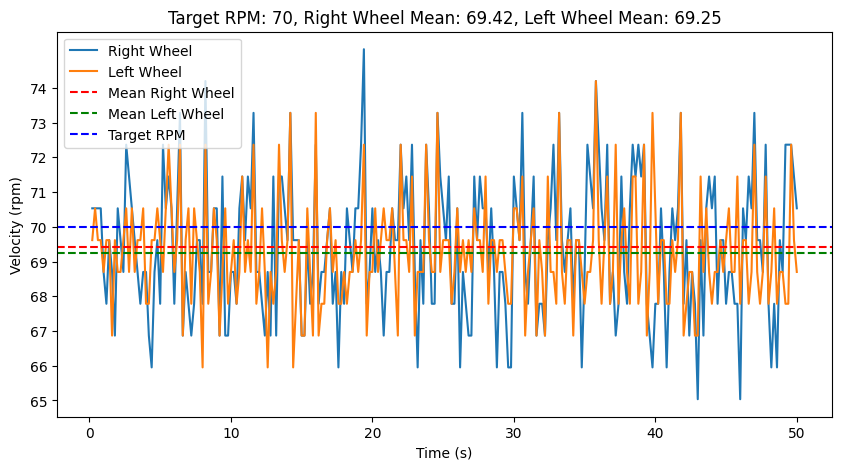

In [226]:
sample_df = pd.DataFrame(columns=['time', 'left_wheel_vel', 'left_wheel_vel', 'rpm'])
sample_df = read_data(EX1_DATA_PATH, EXPR_NUM, rpm=70, id_num=1, base_df=sample_df)
plot_experimet_data(sample_df)
sample_df.describe()

## **สรุปผลการทดลอง**

ผลลัพท์ที่ได้จากการทดลองจะสามารถสั่งเกตได้ว่าเมื่อทดสอบการสั่งการความเร็วของมอเตอร์ทั้งแบบยกลอยและวางกับพื้นให้ผลลัพทธ์ของค่าเฉลี่ยความเร็วของล้อที่ใกล้เคียงกัน แต่เมื่อพิจารณาถึงความแตกต่างของค่าเฉลี่ยความแปรปรวน ในแต่ละความเร็วนั้นพบว่า เมื่อวางหุ่นยนต์กับพื้นมีค่าความแปรปรวนที่สูงกว่าอย่างเห็นได้ชัด ( Left Wheel คือ 1.55238 และ Right Wheel 1.503791 ) โดยความแตกต่างนี้อาจจะเกิดขึ้นจากบนพื้นมีแรงเสียดทาน และแรงอื่น ๆ มากระทำกับล้อ


<center><img src="pic/ex1.png"/></center>

## **Linear Regression Model**

In [227]:
# Fine Linear Regression

from sklearn.linear_model import LinearRegression

In [228]:
def GetLR_Coef(df, zone_start, zone_end):

    # Create the model for the right wheel
    model_right = LinearRegression()
    X = df['rpm'].values.reshape(-1, 1)
    y = df['right_wheel_vel']

    model_right.fit(X, y)

    # Get the model parameters
    right_slope = model_right.coef_
    right_intercept = model_right.intercept_

    # Create the model for the left wheel
    model_left = LinearRegression()
    X = df['rpm'].values.reshape(-1, 1)
    y = df['left_wheel_vel']

    model_left.fit(X, y)

    # Get the model parameters
    left_slope = model_left.coef_
    left_intercept = model_left.intercept_

    getpredrpm = lambda x, m, b: m*x + b
    invgetpredrpm = lambda y, m, b: (y - b)/m

    grid_size = 0.5
    # Plot the linear regression
    fig, ax = plt.subplots()
    ax.scatter(df['rpm'], df['right_wheel_vel'], label='Right Wheel')
    ax.scatter(df['rpm'], df['left_wheel_vel'], label='Left Wheel')
    # Plot the linear regression
    x = np.arange(zone_start, zone_end+grid_size, grid_size)
    # Plot the linear regression
    y = getpredrpm(x, right_slope, right_intercept)
    ax.plot(x, y, label='Right Wheel Linear Regression', color='r')
    y = getpredrpm(x, left_slope, left_intercept)
    ax.plot(x, y, label='Left Wheel Linear Regression', color='g')
    # Plot ideal line
    ax.plot(x, x, label='Ideal Line', color='b', linestyle='--')
    # Add grid
    ax.grid(True)
    ax.legend()
    plt.xticks(np.arange(zone_start,zone_end+2,2))
    plt.yticks(np.arange(zone_start-10,zone_end+10-2,2))
    plt.xlabel('LR Input RPM')
    plt.ylabel('LR Predicted RPM')
    plt.title('Linear Regression for Zone ' + str(zone_start) + ' to ' + str(zone_end))
    plt.show()

    print(f'Left Wheel: Slope = {left_slope[0]}, Intercept = {left_intercept}')
    
    print(f'Right Wheel: Slope = {right_slope[0]}, Intercept = {right_intercept}')

    return right_slope, right_intercept, left_slope, left_intercept

### **Zone of LinearRegression**

In [229]:
zone_1_start = 10
zone_1_end = 40

zone_2_start = 40
zone_2_end = 70

step = 10

#### **Zone1**

In [230]:
df_exp_z1 = pd.DataFrame(columns=['time', 'right_wheel_vel', 'left_wheel_vel', 'rpm'])

for rpm in range(zone_1_start, zone_1_end+step, step):
    for id_num in range(1, 3):
        df_exp_z1 = read_data(EX1_DATA_PATH, EXPR_NUM, rpm, id_num, df_exp_z1)

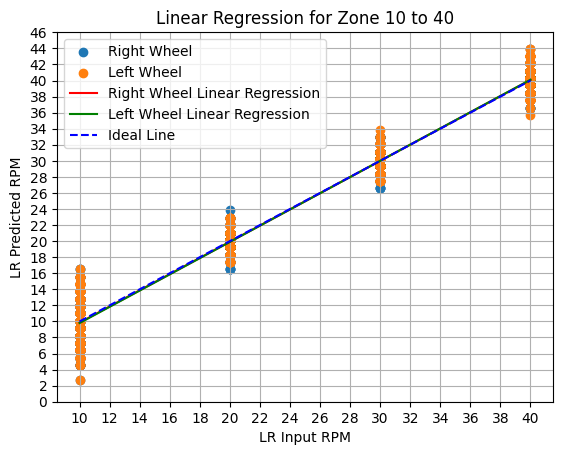

Left Wheel: Slope = 1.010073223731285, Intercept = -0.302280309691227
Right Wheel: Slope = 1.0075084252814017, Intercept = -0.22900038146364565


In [231]:
z1_right_slope, z1_right_intercept, z1_left_slope, z1_left_intercept = GetLR_Coef(df_exp_z1, zone_1_start, zone_1_end)

#### **Zone2**

In [232]:
df_exp_z2 = pd.DataFrame(columns=['time', 'right_wheel_vel', 'left_wheel_vel', 'rpm'])

for rpm in range(zone_2_start, zone_2_end+step, step):
    for id_num in range(1, 3):
        df_exp_z2 = read_data(EX1_DATA_PATH, EXPR_NUM, rpm, id_num, df_exp_z2)

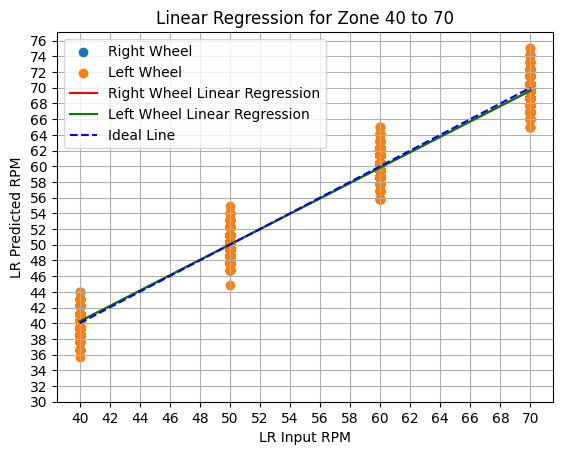

Left Wheel: Slope = 0.9799550216518994, Intercept = 1.0235435573910365
Right Wheel: Slope = 0.9807244537089485, Intercept = 0.9894689225123656


In [233]:
z2_right_slope, z2_right_intercept, z2_left_slope, z2_left_intercept = GetLR_Coef(df_exp_z2, zone_2_start, zone_2_end)

# **2.การทดลองหาความสัมพันธ์ของค่าที่เกิดขึ้นกับหุ่นยนต์ และค่า Wheel Odometry**

ตัวแปรต้น: path การเดินของหุ่นยนต์ 

ตัวแปรตาม: Real_position ที่ได้จากการวัด, Wheel_position (Odom) ที่ได้จากการทำ Forward Kenematics 

ตัวแปรควบคุม: path การเดินของหุ่นยนต์ 

## **สมมติฐาน**  

ค่า Real_position ที่หุ่นยนต์เดินไปนั้นต้องมีค่า Standard Diviation น้อยเมื่อเทียบกับค่า position ที่ได้จาก wheel_odometry (Odom) 

## **ขั้นตอนการทดลอง**

สั่งให้หุ่นเดินตาม path สี่เหลียมและ pose ของหุ่นที่เกิดขึ้น เทียบกับ odom ที่ได้จาก คำนวณผ่าน Forward Kenematics โดยเก็บจาก Time stamped 


In [234]:
EX2_DATA_PATH = cwd + "\\experiment_1"

print(f'Path to the experiment 1 data: {EX2_DATA_PATH}')

Path to the experiment 1 data: c:\Users\mobil\OneDrive\Desktop\FRA532_Exam\src\doc\experiment_1


## **ผลการทดลอง**

In [235]:
ex2_3_data_all_value = pd.DataFrame()
ex2_3_data_all_value_list = []

folder_path = cwd + "\\experiment_2"
file_name_format = 'Experiment_2_id_'

# Count the number of CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, f'{file_name_format}*.csv'))
num_csv_files = len(csv_files)
# print(csv_files)

for i in range(1, num_csv_files+1):
    csv_path = f'{folder_path}/{file_name_format}{i}.csv'
    ex2_data = pd.read_csv(csv_path, index_col=False)
    ex2_3_data_all_value_list.append(ex2_data.iloc[[-1]])

ex2_3_data_all_value = pd.concat(ex2_3_data_all_value_list, ignore_index=True)
ex2_3_data_all_value.dropna(inplace=True)
ex2_3_data_all_value.head()

,time,wheel_odom_x,wheel_odom_y,odom_filter_x,odom_filter_y,true_x,true_y
0,20.200725,2.010064,0.004815,1.994200,-0.009196,2.02,0.0
1,20.201835,2.002676,0.011979,1.998723,0.019753,2.02,0.0
2,20.201112,2.006618,0.015747,1.987791,0.011144,2.02,0.0
3,20.201881,2.004398,-0.026071,1.999405,-0.036554,2.02,0.0
4,20.200556,2.014957,0.004623,2.008251,-0.029003,2.02,0.0


### **Preprocessing Data**

In [236]:
wheel_odom = ex2_3_data_all_value.iloc[:-1,1:3]
compare_df = pd.concat([wheel_odom, x_y_robot], axis=1)
compare_df[['wheel_odom_x']] = compare_df[['wheel_odom_x']].multiply(100)           # change meter to centimeter
compare_df[['wheel_odom_y']] = compare_df[['wheel_odom_y']].multiply(100)           # change meter to centimeter


# Round the values to 3 decimal places
compare_df['wheel_odom_x'] = np.round(compare_df['wheel_odom_x'].astype(float), 3)
compare_df['wheel_odom_y'] = np.round(compare_df['wheel_odom_y'].astype(float), 3)
compare_df['x_robot'] = np.round(compare_df['x_robot'].astype(float), 3)
compare_df['y_robot'] = np.round(compare_df['y_robot'].astype(float), 3)

# Calculate the difference between the two x and y values
compare_df['error_x'] = np.abs(compare_df['wheel_odom_x'] - compare_df['x_robot'])
compare_df['error_y'] = np.abs(compare_df['wheel_odom_y'] - compare_df['y_robot'])
compare_df.dropna(inplace=True) # Drop NaN values



### **Plot Result**

In [237]:
error_x = compare_df['error_x']
error_x = np.array(error_x)
error_y = compare_df['error_y']
error_y = np.array(error_y)
mean_error_x = np.mean(error_x)
mean_error_y = np.mean(error_y)
cov_xy =  np.cov(error_x,error_y)

variance_x = cov_xy[0][0]
variance_y = cov_xy[1][1]
sigma_x= np.sqrt(variance_x)
sigma_y= np.sqrt(variance_y)

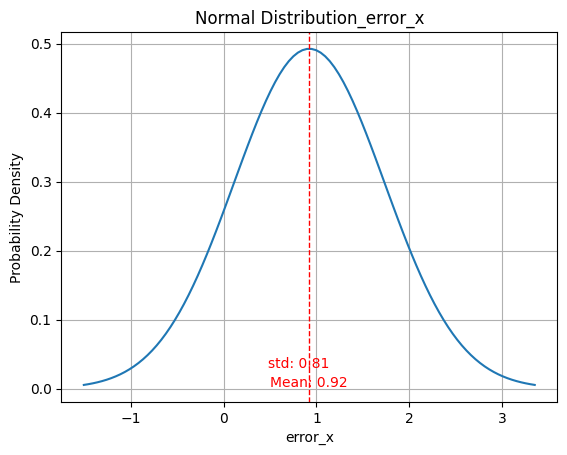

In [238]:
# Generate x values
norm_error_x = np.linspace(mean_error_x - 3 * sigma_x, mean_error_x + 3 * sigma_x, 100)
norm_error_y = np.linspace(mean_error_y - 3 * sigma_y, mean_error_y + 3 * sigma_y, 100)
# Plot the normal distribution
plt.plot(norm_error_x, stats.norm.pdf(norm_error_x, mean_error_x, sigma_x))
plt.axvline(mean_error_x, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_error_x, 0.003, f'Mean: {mean_error_x:.2f}', color='r', fontsize=10, ha='center')
plt.text(sigma_x, 0.03, f'std: {sigma_x:.2f}', color='r', fontsize=10, ha='center')
plt.xlabel("error_x")
plt.ylabel("Probability Density")
plt.title("Normal Distribution_error_x")
plt.grid(True)
plt.show()

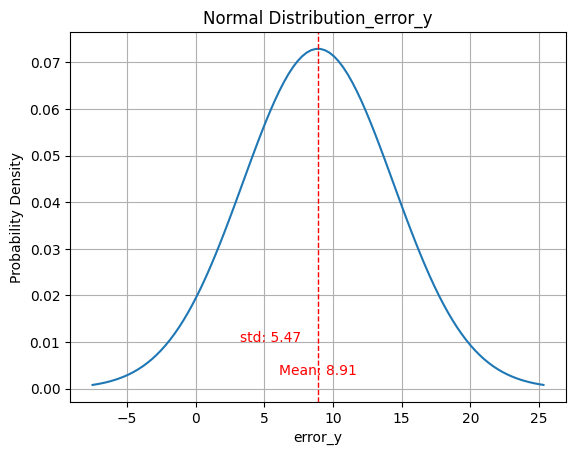

In [239]:
plt.plot(norm_error_y, stats.norm.pdf(norm_error_y, mean_error_y, sigma_y))
plt.axvline(mean_error_y, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_error_y, 0.003, f'Mean: {mean_error_y:.2f}', color='r', fontsize=10,ha='center')
plt.text(sigma_y, 0.01, f'std: {sigma_y:.2f}', color='r', fontsize=10, ha='center')
plt.xlabel("error_y")
plt.ylabel("Probability Density")
plt.title("Normal Distribution_error_y")
plt.grid(True)
plt.show()

## **สรุปผลการทดลอง**

จากการคำนวณหาค่า error ที่เกิดขึ้นจากการเทียบค่า Wheel_odometry ที่ได้จากการคำนวณ forward kinematic กับ real_value จะเห็นได้ว่าค่าที่ได้จากความเป็นจริงมีค่าคลาดเคลื่อนจากความเป็นจริงแต่ค่าที่ได้จาก Wheel_odometry มี error จากค่าจริง โดยมีค่า mean_error_x คือ 0.92 และ variance_x 0.8, mean_error_y คือ 8.84 และ variance_y 5.39 เพราะค่า Wheel_odometry ได้้การคำนวณซึ่งไม่ได้คำนึงถึงปัจจัยภายนอกหลายอื่นๆถึงมีความคลาดเคลื่อน